In [1]:
# from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import copy
import os

In [ ]:
!kaggle datasets download -d hyperclaw79/fakefaces

In [2]:
DATA_DIRECTORY = "/notebooks/data"

## Tuple parameters: (color_mode, offset, fill_value, channels)
MAP_KEYS = {"color": ("rgb", 0, 128, 3), "normaldx": ("rgb", 3, 128, 3), "metal": ("grayscale", 6, 0, 1), "rough": ("grayscale", 7, 128, 1)}

def get_number_of_channels() -> int:
    return 3
    # number_of_channels = 0
    # for map_details in MAP_KEYS.values():
    #     number_of_channels += map_details[3]
    # return number_of_channels

def get_ids_from_csv(csv_path) -> np.ndarray:
    ids = np.loadtxt(csv_path, delimiter=",", dtype=str, usecols=(0))[1:]
    return ids

def get_default_map(details, target_size) -> np.ndarray:
    shape = target_size + (details[3],)
    return np.full(shape=shape, fill_value=details[2], dtype="float32")

## Loads all materials based on the content.csv in the specified directory.
## Each material is a tensor of rank 3 (width, height, channels=8)
## The returned tensor is therefore of rank 4.
def get_materials(directory_path, target_size):
    ids = get_ids_from_csv(directory_path + "/content.csv")
    number_of_materials = len(ids)
    materials = np.zeros(shape=(number_of_materials,) + target_size + (get_number_of_channels(),))
    for (i, id) in enumerate(ids):
        image = np.zeros(shape=target_size + (get_number_of_channels(),))
        for map_key, details in MAP_KEYS.items():
            map_path = f"{directory_path}/{id}_{map_key}.jpg"
            if os.path.exists(map_path):
                map = keras.utils.load_img(
                    path=map_path,
                    color_mode=details[0],
                    target_size=target_size,
                    # keep_aspect_ratio=True
                )
                map = keras.utils.img_to_array(map)
            else:
                map = get_default_map(MAP_KEYS[map_key], target_size)
            for channel_index in range(map.shape[-1]):
                image[:,:,details[1] + channel_index] = map[:,:,channel_index]
        materials[i,:,:,:] = image
    return materials

def load_data(root_directory_path, target_size):
    data_sources = []
    directory = os.fsencode(root_directory_path)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        # if is data directory
        if filename.endswith("_data"):
            directory_path = root_directory_path + f"/{filename}"
            data_sources.append(directory_path)

    all_materials = np.zeros(shape=(0,) + target_size + (get_number_of_channels(),))
    for data_source in data_sources:
        materials = get_materials(data_source, target_size)
        all_materials = np.concatenate((all_materials, materials), axis=0)

    return all_materials

target_size = (64, 64)
# materials = load_data(DATA_DIRECTORY, target_size).astype("float32")
# materials /= 255.



In [3]:
FACES_DIRECTORY = "./fakefaces"

def load_fakefaces(target_size=(64,64)):
    faces = np.zeros(shape=(0,) + target_size + (3,))
    directory = os.fsencode(FACES_DIRECTORY)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg"):
            img = keras.utils.load_img(path=f"{FACES_DIRECTORY}/{filename}", color_mode="rgb", target_size=target_size)
            img_array = keras.utils.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            faces = np.concatenate((faces, img_array), axis=0)
    faces = faces.astype("float32")
    faces /= 255.
    return faces

faces = load_fakefaces()

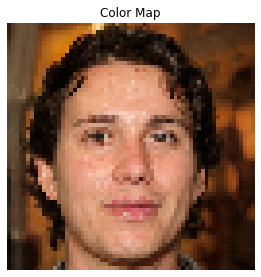

In [6]:
def plot_sample(materials: np.ndarray, sample_number):
    sample = materials[sample_number,:,:,:].copy()
    sample *= 255
    sample = sample.astype(np.uint8)
    plt.figure(figsize=(10,10))

    plt.subplot(2, 2, 1)
    plt.axis("off")
    plt.title("Color Map")
    plt.imshow(sample[:,:,:3])

    # plt.subplot(2, 2, 2)
    # plt.axis("off")
    # plt.title("Normal Map")
    # plt.imshow(sample[:,:,3:6])

    # plt.subplot(2, 2, 3)
    # plt.axis("off")
    # plt.title("Metal Map")
    # plt.imshow(sample[:,:,6:7], cmap='gray', vmin=0, vmax=255)

    # plt.subplot(2, 2, 4)
    # plt.axis("off")
    # plt.title("Roughness Map")
    # plt.imshow(sample[:,:,7:8], cmap='gray', vmin=0, vmax=255)

plot_sample(faces, 5)

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=target_size + (get_number_of_channels(),)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ],
    name="discriminator"
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

In [9]:
latent_dim = 100

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4*4*1024),
        layers.Reshape((4,4,1024)),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(get_number_of_channels(), kernel_size=5, padding="same", activation="sigmoid")
        layers.Conv2DTranspose(get_number_of_channels(), kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
    ],
    name="generator"
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1654784   
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 512)        8389120   
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 256)      20

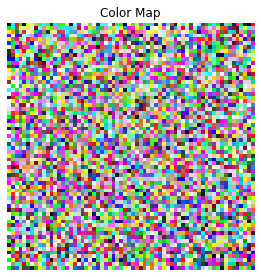

In [10]:
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)
generated_image *= 255
generated_image = generated_image.numpy()

plot_sample(generated_image, 0)

In [11]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.005 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [12]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i,:,:,:3])
            img.save(f"generated_faces/generated_img_{epoch:03d}_{i}.png")

In [15]:
epochs = 1000

callbacks = [
    GANMonitor(num_img=3, latent_dim=latent_dim)
]

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), # based on https://arxiv.org/abs/1511.06434
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy()
)
history = gan.fit(faces, epochs=epochs, batch_size=128, callbacks=callbacks)

Epoch 1/1000
50/50 [==============================] - 3s 48ms/step - d_loss: 0.6089 - g_loss: 1.0573
Epoch 2/1000
50/50 [==============================] - 2s 48ms/step - d_loss: 0.7009 - g_loss: 0.8170
Epoch 3/1000
50/50 [==============================] - 2s 49ms/step - d_loss: 0.7030 - g_loss: 0.7512
Epoch 4/1000
50/50 [==============================] - 2s 48ms/step - d_loss: 0.7022 - g_loss: 0.7277
Epoch 5/1000
50/50 [==============================] - 2s 48ms/step - d_loss: 0.6956 - g_loss: 0.7192
Epoch 6/1000
50/50 [==============================] - 2s 48ms/step - d_loss: 0.6977 - g_loss: 0.7096
Epoch 7/1000
50/50 [==============================] - 2s 48ms/step - d_loss: 0.6991 - g_loss: 0.7069
Epoch 8/1000
50/50 [==============================] - 2s 49ms/step - d_loss: 0.6977 - g_loss: 0.7216
Epoch 9/1000
50/50 [==============================] - 2s 49ms/step - d_loss: 0.6958 - g_loss: 0.7185
Epoch 10/1000
50/50 [==============================] - 2s 49ms/step - d_loss: 0.6953 - g_lo

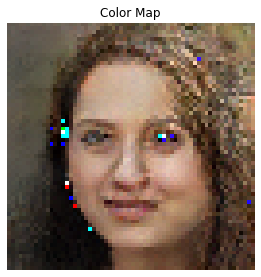

In [26]:
random_latent_vectors = tf.random.normal(shape=(10, 100))
generated_materials = gan.generator(random_latent_vectors)
# generated_materials *= 255
generated_materials = generated_materials.numpy()
# generated_materials = generated_materials.astype("int8")

plot_sample(generated_materials, 3)

In [ ]:
color_map = keras.utils.array_to_img(generated_materials[0,:,:,:3])
normal_map = keras.utils.array_to_img(generated_materials[0,:,:,3:6])
metal_map = keras.utils.array_to_img(generated_materials[0,:,:,6:7])
rough_map = keras.utils.array_to_img(generated_materials[0,:,:,7:8])

color_map.save(f"generated_test/0_color.jpg")
normal_map.save(f"generated_test/0_normal.jpg")
metal_map.save(f"generated_test/0_metal.jpg")
rough_map.save(f"generated_test/0_rough.jpg")